In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

module_path = os.path.abspath(os.path.join("../.."))
sys.path.append(module_path)

## Dataset and hyperparameters loading

In [3]:
from torchvision.transforms.v2 import Compose
from hyperparameters import load_hyperparameters_from_json

from SLTDataset import SLTDataset
from posecraft.Pose import Pose


DATASET = "GSL"
EXPERIMENT_ID = "frosty-haze-24"
SAMPLE_IDX = 509

dataset_path = f"/mnt/disk3Tb/slt-datasets/{DATASET}"
experiment_path = f"results/{DATASET}/{EXPERIMENT_ID}"
hp = load_hyperparameters_from_json(f"{experiment_path}/hp.json")
output_path = f"{experiment_path}/interp/{SAMPLE_IDX}/"
os.makedirs(output_path, exist_ok=True)
transparent_plot = False

landmarks_mask = Pose.get_components_mask(hp["LANDMARKS_USED"])
transforms: Compose = Compose(hp["TRANSFORMS"])

train_dataset = SLTDataset(
    data_dir=dataset_path,
    split="train",
    input_mode=hp["INPUT_MODE"],
    output_mode=hp["OUTPUT_MODE"],
    transforms=transforms,
    max_tokens=hp["MAX_TOKENS"],
)
test_dataset = SLTDataset(
    data_dir=dataset_path,
    split="test",
    input_mode=hp["INPUT_MODE"],
    output_mode=hp["OUTPUT_MODE"],
    transforms=transforms,
    max_tokens=hp["MAX_TOKENS"],
)

Loaded metadata for dataset: The Greek Sign Language (GSL) Dataset
Loaded train annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 8821/8821 [00:00<00:00, 220439.81it/s]


Dataset loaded correctly

Loaded metadata for dataset: The Greek Sign Language (GSL) Dataset
Loaded test annotations at /mnt/disk3Tb/slt-datasets/GSL/annotations.csv


Validating files: 100%|██████████| 881/881 [00:00<00:00, 203411.97it/s]

Dataset loaded correctly



### Display sample

In [4]:
from IPython.display import HTML

# avoid using the last transform as it flattens the keypoints
visual_transforms: Compose = Compose(hp["TRANSFORMS"][:-1])
anim = test_dataset.visualize_pose(SAMPLE_IDX, transforms=visual_transforms)
HTML(anim.to_jshtml())

<IPython.core.display.Javascript object>

In [5]:
anim.save(f"{output_path}/sample.mp4", writer="ffmpeg")

In [6]:
import torch

device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else ("cuda" if torch.cuda.is_available() else "cpu")
)

src, tgt = test_dataset[SAMPLE_IDX]
src = src.unsqueeze(0)
tgt = tgt.unsqueeze(0)
src = src.to(device)
tgt = tgt.to(device)

## Model

### Definition

In [7]:
import glob
from LightningKeypointsTransformer import LKeypointsTransformer

checkpoint_path = glob.glob(f"{experiment_path}/best*")[0]
try:
    l_model = LKeypointsTransformer.load_from_checkpoint(checkpoint_path)
    model = l_model.model
    translator = l_model.translator
except:
    from helpers import load_from_old_checkpoint

    model, translator = load_from_old_checkpoint(
        checkpoint_path, hp, device, landmarks_mask, train_dataset
    )

/home/ostanchi/miniconda3/envs/captum/lib/python3.10/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/ostanchi/slt_models_tryout/src/helpers.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be 

In [8]:
model = model.to(device)
model = model.eval()

In [9]:
BOS_IDX = train_dataset.tokenizer.cls_token_id
EOS_IDX = train_dataset.tokenizer.sep_token_id

### Interpretability

In [10]:
from interp.plot_functions import *

In [11]:
translation = translator.translate(src, model, "greedy", train_dataset.tokenizer)
translation = ["BOS " + s + " EOS" for s in translation]
translation = translation[0].split()
translation

['BOS', 'ΜΩΡΟ', 'ΓΕΝΝΩ', 'ΝΩΡΙΣ', 'EOS']

#### Encoder Self-Attention

In [12]:
attn_output_weights_list = []


def attention_hook(module, input, output):  # input: (query, key, value)
    _, attn_output_weights = output  # output: (attn_output, attn_output_weights)
    attn_output_weights_list.append(attn_output_weights[0].cpu().detach().numpy())


hook_handles = []
for layer in range(hp["NUM_ENCODER_LAYERS"]):
    self_attn_module = model.transformer.encoder.layers[layer].self_attn
    hook_handles.append(self_attn_module.register_forward_hook(attention_hook))

# Inference
translator.greedy_decode(src, model, BOS_IDX, EOS_IDX)

for handle in hook_handles:
    handle.remove()

In [13]:
plot_encoder_layers(attn_output_weights_list, hp, output_path, transparent_plot)

<IPython.core.display.Javascript object>

#### Decoder Self-Attention

In [14]:
attn_output_weights_list = []


def attention_hook(module, input, output):  # input: (query, key, value)
    _, attn_output_weights = output  # output: (attn_output, attn_output_weights)
    # print(output[0].shape, output[1].shape)
    attn_output_weights_list.append(attn_output_weights[0].cpu().detach().numpy())


hook_handles = []
for layer in range(hp["NUM_DECODER_LAYERS"]):
    self_attn_module = model.transformer.decoder.layers[layer].self_attn
    hook_handles.append(self_attn_module.register_forward_hook(attention_hook))

# Inference
translator.greedy_decode(src, model, BOS_IDX, EOS_IDX)

for handle in hook_handles:
    handle.remove()

In [15]:
plot_decoder_layers(
    attn_output_weights_list, hp, output_path, translation, "self", transparent_plot
)

<IPython.core.display.Javascript object>

#### Decoder Cross-Attention

In [16]:
attn_output_weights_list = []


def attention_hook(module, input, output):  # input: (query, key, value)
    _, attn_output_weights = output  # output: (attn_output, attn_output_weights)
    # print(output[0].shape, output[1].shape)
    attn_output_weights_list.append(attn_output_weights[0].cpu().detach().numpy())


hook_handles = []
for layer in range(hp["NUM_DECODER_LAYERS"]):
    multihead_attn_module = model.transformer.decoder.layers[layer].multihead_attn
    hook_handles.append(multihead_attn_module.register_forward_hook(attention_hook))

# Inference
translator.greedy_decode(src, model, BOS_IDX, EOS_IDX)

for handle in hook_handles:
    handle.remove()

In [17]:
plot_decoder_layers(
    attn_output_weights_list, hp, output_path, translation, "cross", transparent_plot
)

<IPython.core.display.Javascript object>

---

In [18]:
for attn_output_weights in attn_output_weights_list:
    print(attn_output_weights.shape)

(1, 30)
(1, 30)
(1, 30)
(1, 30)
(2, 30)
(2, 30)
(2, 30)
(2, 30)
(3, 30)
(3, 30)
(3, 30)
(3, 30)
(4, 30)
(4, 30)
(4, 30)
(4, 30)


In [19]:
attn_output_weights_list = reorganize_list(attn_output_weights_list, hp["NUM_DECODER_LAYERS"])

In [20]:
attn_output_weights_list = attn_output_weights_list[:hp["NUM_DECODER_LAYERS"]*1] #keep first layer only

In [21]:
for attn_output_weights in attn_output_weights_list:
    print(attn_output_weights.shape)

(1, 30)
(2, 30)
(3, 30)
(4, 30)


In [22]:
def norm_min_max(t):
    t = t.copy()
    t -= t.min()
    t /= t.max()
    return t

In [23]:
attn_weights = np.zeros_like(attn_output_weights_list[-1])
for i, attn_output_weights in enumerate(attn_output_weights_list):
    attn_weights[i,:] = norm_min_max(attn_output_weights[i,:]) #if we do not normalize the output is similar to the last inference
attn_weights.shape

(4, 30)

In [24]:
print(attn_weights)

[[0.3731783  0.5496598  0.7041902  0.6945201  0.862339   1.
  0.91862893 0.64980555 0.51584595 0.4349885  0.29994902 0.30043405
  0.38493624 0.31151167 0.23256811 0.3657257  0.520265   0.41483724
  0.30501753 0.         0.07042687 0.1462882  0.17352897 0.12248312
  0.06570046 0.05880055 0.08243905 0.16105296 0.20691338 0.27314967]
 [0.07174117 0.07396196 0.08119262 0.04860008 0.07288202 0.10371155
  0.07362863 0.         0.11202402 0.3351463  0.50941795 0.7480562
  1.         0.79973644 0.53529817 0.38762364 0.30325356 0.17486213
  0.22718221 0.24899298 0.18558356 0.1762837  0.2360198  0.26661554
  0.11738652 0.46985656 0.6147028  0.66726714 0.5701305  0.48506007]
 [0.0141662  0.00373264 0.         0.05124911 0.11760514 0.1632965
  0.17200701 0.15958643 0.13798042 0.17024569 0.19412754 0.30275884
  0.3935846  0.30744454 0.24588105 0.19414584 0.11778202 0.09085339
  0.08405854 0.17068355 0.149524   0.1469185  0.17094922 0.20563765
  0.19927444 0.51121956 0.77463174 1.         0.9607543 

In [25]:
print(attn_output_weights_list[-1])

[[0.03270857 0.03765246 0.04222269 0.04175977 0.04631116 0.05009333
  0.04758278 0.04080589 0.03782695 0.03627785 0.03236297 0.03159384
  0.03209288 0.03014739 0.02891603 0.03283125 0.03603853 0.0333515
  0.03029566 0.02318774 0.02514466 0.02728594 0.02814919 0.02715473
  0.02599391 0.02555958 0.02633662 0.02825578 0.02974231 0.03231803]
 [0.02523855 0.02567356 0.02635563 0.0254115  0.02619334 0.02707631
  0.02624682 0.023862   0.02740846 0.03418328 0.03979746 0.04682743
  0.05387206 0.0475999  0.03967331 0.03564391 0.0331521  0.02907977
  0.03039296 0.03045217 0.02856491 0.02846139 0.03037301 0.03141263
  0.02674598 0.03718119 0.04160088 0.0430688  0.04036739 0.03808327]
 [0.02139432 0.0208639  0.02068563 0.02315516 0.0263321  0.02851103
  0.02898213 0.02849548 0.02737817 0.02880106 0.02981024 0.03487655
  0.03922738 0.0351101  0.03220964 0.02972847 0.02613521 0.02494068
  0.02461646 0.02857189 0.02761259 0.02747601 0.02859458 0.03028212
  0.03005021 0.04464491 0.05706895 0.06766671 0

In [26]:
attn_output_weights_list[-1].sum()

4.0

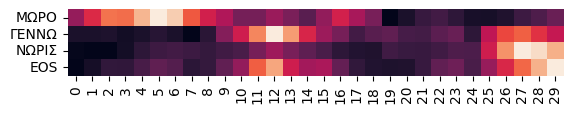

In [27]:
%matplotlib inline
src_sent = np.arange(hp["MAX_FRAMES"])
tgt_sent = translation[1 : attn_weights.shape[0] + 1]
sns.heatmap(
    attn_weights,
    xticklabels=src_sent,
    yticklabels=tgt_sent,
    square=True,
    cbar=False,
)  # vmin=0.0, vmax=1.0)
plt.show()

<Axes: >

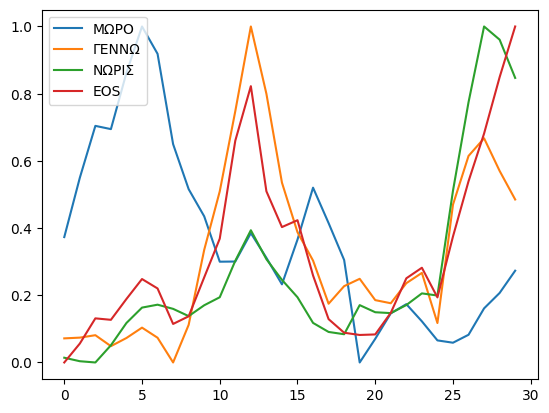

In [28]:
import pandas as pd
%matplotlib inline
df_attn_weights = pd.DataFrame(attn_weights.T)
df_attn_weights.columns = tgt_sent
sns.lineplot(df_attn_weights, dashes=False)

In [29]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

%matplotlib notebook

def get_update(scatter, keypoints_all_frames, bars, attn_weights):
    def update(frame):
        # Reshape keypoints to have each pair (x, y) in a row
        keypoints = keypoints_all_frames[frame, :].view(-1, (3 if hp['USE_3D'] else 2))
        x = keypoints[:, 0]
        y = keypoints[:, 1]
        scatter.set_offsets(torch.stack((x, y), dim=-1))
        
        bar_heights = attn_weights[:, frame]
        for bar, height in zip(bars, bar_heights):
            bar.set_height(height)
        
        return scatter, bars
    return update

def show_example(x: torch.Tensor, t: torch.Tensor, attn_weights: np.ndarray, b: int = 0):
    """
    Displays keypoints as a pyplot visualization with an animated bar chart.
    Args:
    - x (torch.Tensor): Tensor of shape (B, F, L) where L is the consecutive x, y values of keypoints.
    - t (torch.Tensor): Tensor of shape (B, MAX_TOKENS) storing tokenized target sentences.
    - attn_weights (np.ndarray): Array of shape (N, F) where N is the number of words and F is the number of frames.
    - b (int): Batch index to visualize.
    """
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.invert_yaxis()  # Invert y-axis so origin is at top-left

    tgt_list = [x.item() for x in t[b, :]]
    idx2word = train_dataset.tokenizer.convert_ids_to_tokens(tgt_list)
    idx2word_filtered = [word for word in idx2word if 'PAD' not in word and word != 'BOS']
    ax.set_title(" ".join(idx2word_filtered))

    scatter = ax.scatter([], [], s=10)

    keypoints_all_frames = x[b, :, :]
    
    ax_bar = fig.add_axes([0.65, 0.63, 0.25, 0.25])
    bars = ax_bar.bar(idx2word_filtered, attn_weights[:, 0], color='blue')
    ax_bar.set_ylim(0, np.max(attn_weights))
    ax_bar.set_xticklabels(idx2word_filtered, rotation=90)

    func_update = get_update(scatter, keypoints_all_frames, bars, attn_weights)

    num_frames = keypoints_all_frames.shape[0]
    anim = FuncAnimation(fig, func_update, frames=num_frames, interval=50, blit=True)
    anim.save(f"{output_path}/sample_bars.mp4", writer="ffmpeg")

    return HTML(anim.to_jshtml())

In [30]:
show_example(src.cpu(), tgt.cpu(), attn_weights)

<IPython.core.display.Javascript object>

/tmp/ipykernel_1467344/3754119733.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_bar.set_xticklabels(idx2word_filtered, rotation=90)


---

#### Decoder `sa_block` & `mha_block`

In [31]:
from interp.InterpTransformer import clear_intermediate_outputs

In [32]:
clear_intermediate_outputs()

In [33]:
translator.greedy_decode(src, model, BOS_IDX, EOS_IDX)

tensor([[  2, 274, 189, 276,   3]], device='cuda:0')

In [34]:
from interp.InterpTransformer import intermediate_outputs

In [35]:
intermediate_outputs = {
    key: [tensor[0].cpu().detach().numpy() for tensor in value]
    for key, value in intermediate_outputs.items()
}

In [36]:
plot_intermediate_outputs(
    intermediate_outputs, hp, output_path, translation, transparent_plot
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
diff_sa_mha_block = []
for t1, t2 in zip(intermediate_outputs["sa_block"], intermediate_outputs["mha_block"]):
    diff = t1 - t2

    # normalize to [-1,1]
    diff -= diff.min()
    diff /= diff.max()
    diff *= 2
    diff -= 1

    diff_sa_mha_block.append(diff)
diff_sa_mha_block = {"diff_sa_block_mha_block": diff_sa_mha_block}

In [38]:
plot_intermediate_outputs(
    diff_sa_mha_block, hp, output_path, translation, transparent_plot
)

<IPython.core.display.Javascript object>

In [39]:
tgt_length = len(translation) - 1  # from BOS to EOS-1
attn_output_weights_list = reorganize_list(
    diff_sa_mha_block["diff_sa_block_mha_block"], hp["NUM_DECODER_LAYERS"]
)
for i in range(0, len(attn_output_weights_list), tgt_length):
    print(f"Layer {i // tgt_length + 1}:")
    for j in range(i, i + tgt_length):
        w = attn_output_weights_list[j]
        print(f"{w.shape} → {w.mean():>7.3f}")

Layer 1:
(1, 16) →   0.139
(2, 16) →   0.064
(3, 16) →  -0.266
(4, 16) →  -0.231
Layer 2:
(1, 16) →   0.233
(2, 16) →   0.189
(3, 16) →   0.103
(4, 16) →   0.027
Layer 3:
(1, 16) →   0.220
(2, 16) →   0.131
(3, 16) →   0.056
(4, 16) →  -0.051
Layer 4:
(1, 16) →   0.196
(2, 16) →   0.210
(3, 16) →  -0.163
(4, 16) →  -0.059
